<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    bool   
 8   restecg   920 non-null    object 
 9   thalch    920 non-null    float64
 10  exang     920 non-null    bool   
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    object 
 13  ca        920 non-null    float64
 14  thal      920 non-null    object 
 15  num       920 non-null    int64  
dtypes: bool(2), float64(5), int64(3), object(6)
memory usage: 102.5+ KB
None
               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  920

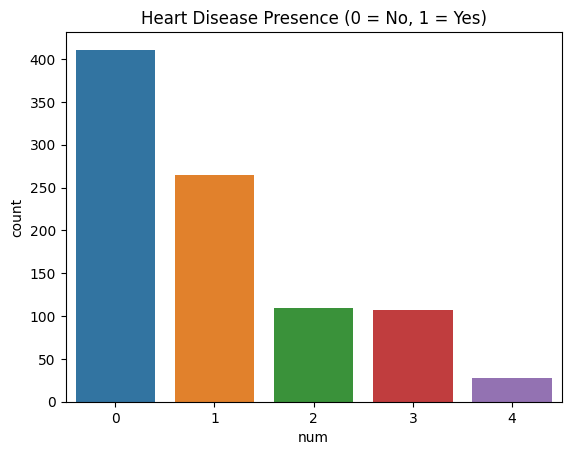

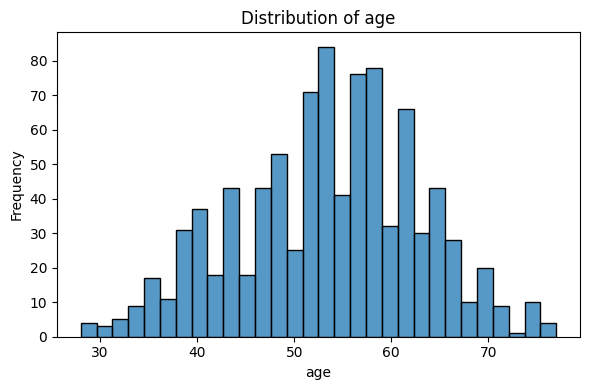

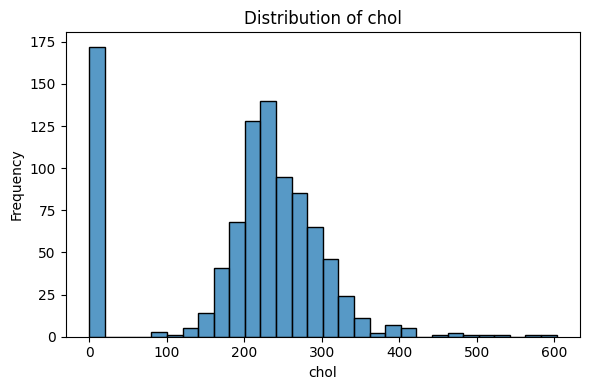

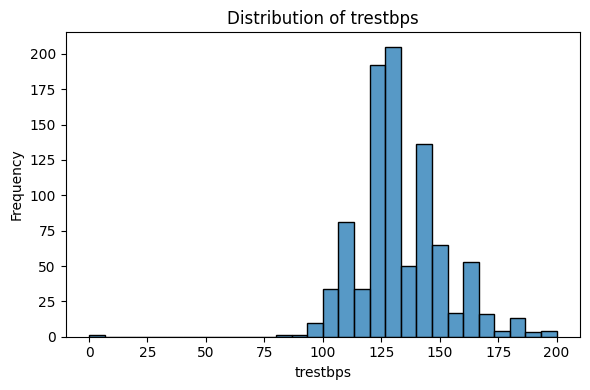

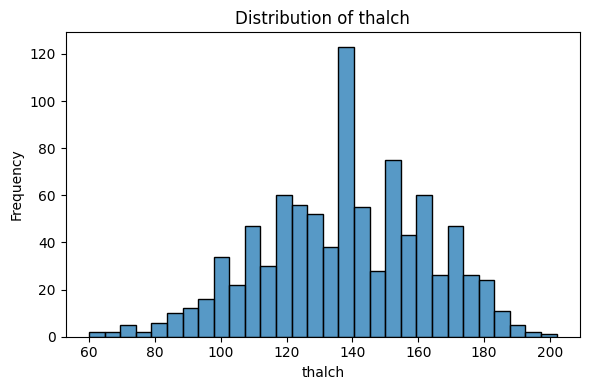

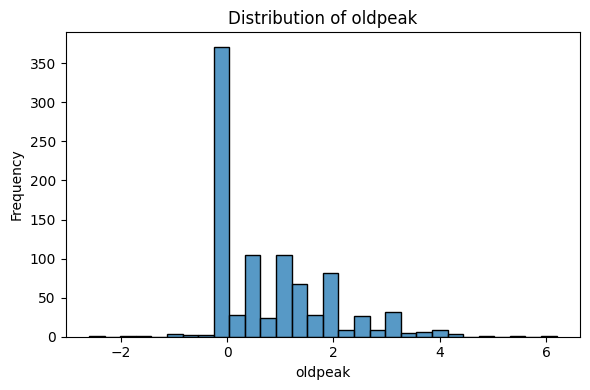

Accuracy: 0.78


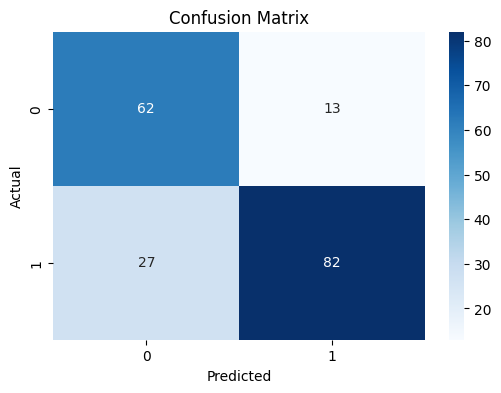

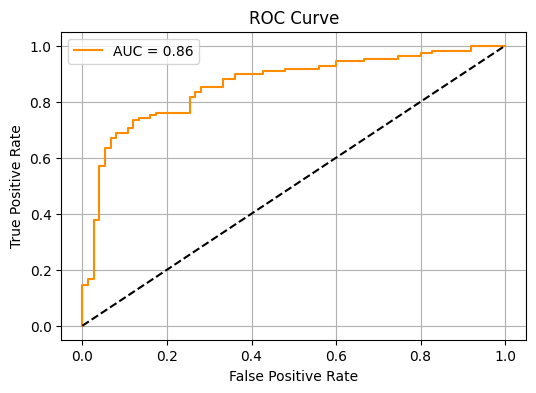

     Feature  Coefficient
9    oldpeak     0.656240
1        sex     0.652563
2         cp    -0.616789
11        ca     0.580996
4       chol    -0.543344
8      exang     0.509606
7     thalch    -0.362219
5        fbs     0.189224
10     slope    -0.185647
0        age     0.141238
12      thal     0.136769
6    restecg     0.131244
3   trestbps     0.032284


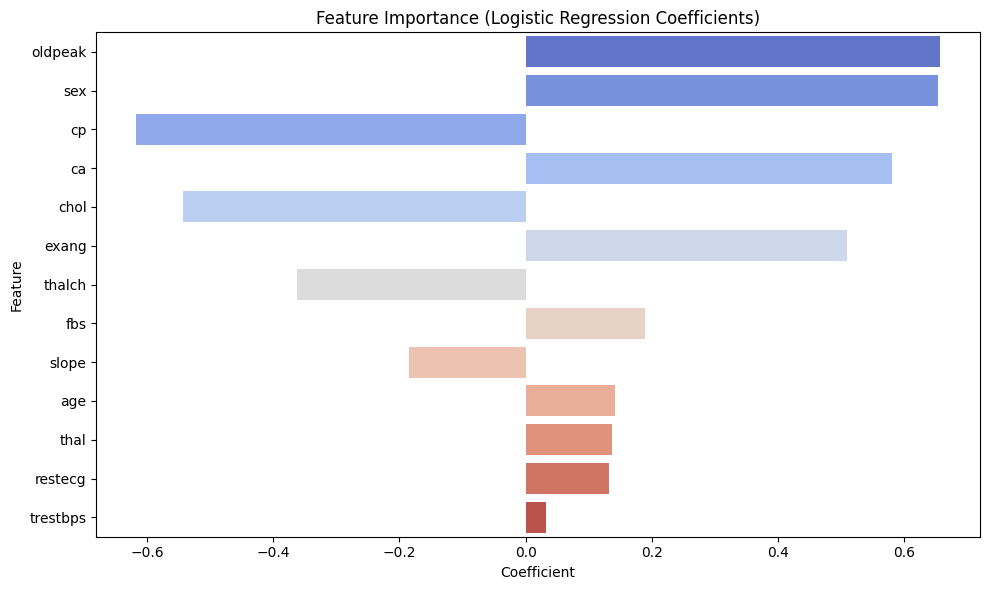

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# load the dataset
df = pd.read_csv('heart.csv')

# remove any duplicate rows
df = df.drop_duplicates()

# fill missing numeric values with median
numeric_cols = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# fill missing categorical values with mode
categorical_cols = ['fbs', 'restecg', 'exang', 'slope', 'thal']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# convert boolean-like columns to actual boolean
df['fbs'] = df['fbs'].map({True: True, False: False, 'True': True, 'False': False})
df['exang'] = df['exang'].map({True: True, False: False, 'True': True, 'False': False})

# clean and standardize categorical text
df['sex'] = df['sex'].str.title()
df['cp'] = df['cp'].str.lower().str.strip()
df['restecg'] = df['restecg'].str.lower().str.strip()
df['slope'] = df['slope'].str.lower().str.strip()
df['thal'] = df['thal'].str.lower().str.strip()

# reset index 
df = df.reset_index(drop=True)

# eda section 

# view basic dataset info
print(df.info())
print(df.describe())

# visualize heart disease presence
sns.countplot(data=df, x='num')
plt.title("Heart Disease Presence (0 = No, 1 = Yes)")
plt.show()

# plot distribution of important features
features_to_plot = ['age', 'chol', 'trestbps', 'thalch', 'oldpeak']
for col in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# model training section

# clean column names for consistency
df.columns = df.columns.str.strip().str.lower()

# convert original multiclass 'num' column to binary target (0 or 1)
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# remove unnecessary columns
df.drop(['id', 'dataset', 'num'], axis=1, inplace=True)

# encode object/categorical columns into numeric values
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# split data into features (X) and target (y)
X = df.drop('target', axis=1)
y = df['target']

# split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features using standard scaler for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# evaluation section

# make predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# print accuracy score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# feature importance section

# get coefficients from logistic regression
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

# sort features by absolute importance
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# print feature coefficients
print(feature_importance[['Feature', 'Coefficient']])

# visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=feature_importance,
    palette='coolwarm'
)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()
